In [1]:
from deeprobust.graph.data import Dataset
from deeprobust.graph.defense import GCN
from deeprobust.graph.global_attack import MinMax
from deeprobust.graph.utils import preprocess, normalize_adj_tensor
import torch.optim as optim
import torch.nn.functional as F
from utils import *
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn.models import GAT

In [2]:
#If missing imports, clone https://github.com/ChandlerBang/pytorch-gnn-meta-attack?tab=readme-ov-file

In [3]:
import sys
import argparse

sys.argv = [
    'notebook',
    '--seed', '15',
    '--epochs', '100',
    '--lr', '0.01',
    '--hidden', '16',
]

# Now use argparse as usual
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=15, help='Random seed.')
parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--hidden', type=int, default=16, help='Number of hidden units.')

args = parser.parse_args()
device = 'cpu'
print(args)

Namespace(seed=15, epochs=100, lr=0.01, hidden=16)


In [4]:
data = Dataset(root='/tmp/', name='cora')
adj, features, labels = data.adj, data.features, data.labels
adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False)
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

Loading cora dataset...
Done!
Selecting 1 largest connected components


In [5]:
data = Dataset(root='/tmp/', name='cora')
adj, features, labels = data.adj, data.features, data.labels
adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False)
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test
victim_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                    nhid=16, dropout=0.5, weight_decay=5e-4, device='cpu').to('cpu')
victim_model.fit(features, adj, labels, idx_train)
model = MinMax(model=victim_model, nnodes=adj.shape[0], loss_type='CE', device='cpu').to('cpu')

Loading cora dataset...
Selecting 1 largest connected components


In [6]:
def attack_sweep(model, features, adj, labels, idx_train, idx_val, max_perturbations=2000, step=50):
    mod_adjs = []
    idx = []

    for i in range(0, max_perturbations + 1, step):
        idx.append(i)
        model.attack(features, adj, labels, idx_train, n_perturbations=i)
        mod_adjs.append(model.modified_adj.clone())
        
    return mod_adjs, idx

In [7]:
modified_adjs, idxs = attack_sweep(model, features, adj, labels, idx_train, idx_val)

100%|█████████████████████████████████████████| 200/200 [05:04<00:00,  1.52s/it]


In [8]:
gat_acc = []

for adj in modified_adjs:
    adj = normalize_adj_tensor(adj)
    edge_index, _ = dense_to_sparse(adj)
    device='cpu'
    edge_index = edge_index.to(device)
    
    if device != 'cpu':
        gcn = gcn.to(device)
        
    gatv1 = GAT(
        in_channels=features.shape[1],
        num_layers=1,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv1.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv1.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = F.log_softmax(gatv1(features, edge_index), dim=1)

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv1.parameters(), max_norm=1.0)
        optimizer.step()

    gatv1.eval()
    output = F.log_softmax(gatv1(features, edge_index), dim=1)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test]).item()
    gat_acc.append(acc_test)

In [9]:
gat2_acc = []

for adj in modified_adjs:
    adj = normalize_adj_tensor(adj)
    edge_index, _ = dense_to_sparse(adj)
    device='cpu'
    edge_index = edge_index.to(device)
    
    if device != 'cpu':
        gcn = gcn.to(device)
        
    gatv2 = GAT(
        v2=True,
        in_channels=features.shape[1],
        num_layers=1,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv2.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv2.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = F.log_softmax(gatv2(features, edge_index), dim=1)

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv2.parameters(), max_norm=1.0)
        optimizer.step()

    gatv2.eval()
    output = F.log_softmax(gatv2(features, edge_index), dim=1)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test]).item()
    gat2_acc.append(acc_test)

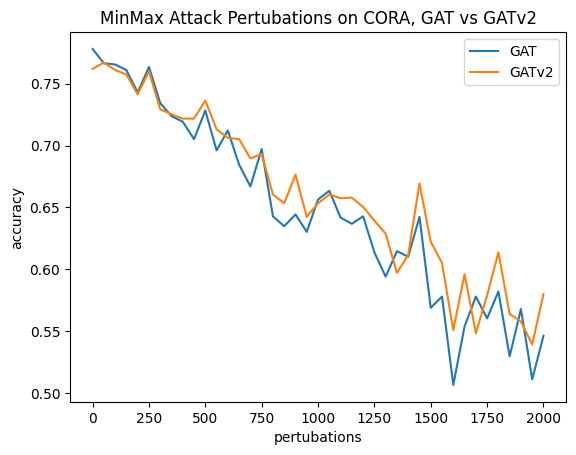

In [10]:
import matplotlib.pyplot as plt
plt.xlabel("pertubations")
plt.ylabel("accuracy")
plt.title("MinMax Attack Pertubations on CORA, GAT vs GATv2")
plt.plot(idxs, gat_acc, label="GAT")
plt.plot(idxs, gat2_acc, label="GATv2")
plt.legend()